# The Battle of Neighborhoods

## The problem

A famous chef of Italian Cuisine wants to open a 5 stars restaurant in Bristol.

He is not interested in a commercial area, not excluded, but mostly to a very selected and quite one. The presence of the competitors of same cuisine should be low but, he is counting of support of other international cuisine for create highly gourmet event.

The focus is to find a suitable neighborhood for the purpose.

### The background

Bristol is a big city in South West England and has 35 wards and about 100 neighborhoods. It's a very huge district but only the urban will be considered.

## Data

### Collecting it

In order to gathering the right data, different sources will be used which will require techniques of sgrabbing.

The data related of:

- _Wards and Population_ will be exported in csv format from https://www.doogal.co.uk/AdministrativeAreas.php?district=E06000023
- _Neighborhood_ will be sgrabbed from wikipedia pages and joing with wikimedia API will fetch the coordinates
- _Crime_ data will downloaded from https://opendata.bristol.gov.uk/explore/dataset/crime-recorded-by-police-by-selected-offence-groups-in-bristol-by-ward/export/?disjunctive.ward_name
- _House price_ will be get from https://www.bristolpost.co.uk/news/bristol-news/house-prices-bristol-2018-postcode-2279067

The data to collect for each area for restaurants will be provided by using the Foursquare APIs where for each neighborhood coordinates will be used the explore functionality within 1000 meter radius and limited to 100 venues and the price parameter with value 3,4 

### How it will be used to solve the problem

The main purpose of data is to show plots with Folium package by using the coordinates which suggest the right area. Additionally techniques of clustering will be used for aggregate those neighborhoods with strong similarities.

### Installing the libraries

In [1]:
# installing few packages
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geocoder
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import geocoder
import folium # map rendering library

!pip install BeautifulSoup4
!pip install wget 
!pip install lxml

import pandas as pd
import numpy as np
import wget
import urllib.request
import requests
from pandas.io.json import json_normalize

import requests

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

from math import *
import math

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
   

### Utility: Functions

In [2]:
# finding a centroid of a set of coordinates
def findCenter(xList, yList, coordinates):
    xCenter = np.sum(xList)/len(xList)
    yCenter = np.sum(yList)/len(yList)
    coordinates.append(xCenter)
    coordinates.append(yCenter)
    coordinates.append(len(xList))
    return coordinates

def distance(lat1, lng1, lat2, lng2):
    #return distance as meter if you want km distance, remove "* 1000"
        
    #math.sqrt((bristol_venues['Locality Latitude']-bristol_venues['Venue Latitude'])**2+(bristol_venues['Locality Longitude']-bristol_venues['Venue Longitude'])**2)

    radius = 6371 * 1000 

    dLat = (lat2-lat1) * math.pi / 180
    dLng = (lng2-lng1) * math.pi / 180

    lat1 = lat1 * math.pi / 180
    lat2 = lat2 * math.pi / 180

    val = sin(dLat/2) * sin(dLat/2) + sin(dLng/2) * sin(dLng/2) * cos(lat1) * cos(lat2)    
    ang = 2 * atan2(sqrt(val), sqrt(1-val))
    return radius * ang

# ref. https://pbpython.com/weighted-average.html
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return round((d * w).sum() / w.sum())
    except ZeroDivisionError:
        return round(d.mean())

In [3]:
CLIENT_ID = 'P3ST2DNORPJI4CFEP1PCHSDTP3GZVNV3DZYXFIVMIWZ140NM' # your Foursquare ID
CLIENT_SECRET = 'YQL53TVB4HMBT2PFVX0O3AGMPQDF4XHPA2WJMBCJTFAWPHKC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

### Get Bristol ward

ref: https://www.doogal.co.uk/AdministrativeAreas.php?district=E06000023

The _df_postcode_census_ contains few interesting informations like:
* Population
* Average Incoming

The limit of this dataset is to have just the Ward information.

In [4]:
df_postcode_census = pd.read_csv("https://github.com/savamo/DataScienceCertification/raw/master/BS%20postcodes.csv")
df_postcode_census.to_csv("df_postcode_census.csv")
print(df_postcode_census.columns)
df_postcode_census.drop(['In Use?',
                                  'Latitude',
                                  'Longitude',
                                  'Easting',
                                  'Northing',
                                  'Introduced',
                                  'Terminated',
                                  'Parish',
                                  'Parish Code',
                                  'National Park',
                                  'Country',
                                  'User Type',
                                  'Quality',
                                  'Last updated',
                                  'Built up area',
                                  'Built up sub-division',
                                  'Plus Code',
                                  'Water company',
                                  'Census output area',
                                  'Postcode area',
                                  'Nearest station',
                                  'Distance to station',
                                  'Local authority',
                                  'Altitude',
                                  'Constituency Code',
                                  'Rural/urban',
                                  'Police force'
                                 ], axis=1, inplace=True)

df_postcode_census.to_csv("df_postcode_census.csv")
df_postcode_census

Index(['Postcode', 'In Use?', 'Latitude', 'Longitude', 'Easting', 'Northing',
       'Grid Ref', 'County', 'District', 'Ward', 'District Code', 'Ward Code',
       'Country', 'County Code', 'Constituency', 'Introduced', 'Terminated',
       'Parish', 'National Park', 'Population', 'Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Constituency Code',
       'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Postcode area',
       'Postcode district', 'Police force', 'Water company', 'Plus Code',
       'Average Income'],
      dtype='object')


,Postcode,Grid Ref,County,District,Ward,District Code,Ward Code,County Code,Constituency,Population,Households,Lower layer super output area,Region,London zone,LSOA Code,MSOA Code,Middle layer super output area,Index of Multiple Deprivation,Postcode district,Average Income
0,BS1 1AD,ST602734,Bristol,"Bristol, City of",Lawrence Hill,E06000023,E05010907,E11000003,Bristol West,NaN,NaN,Bristol 054D,South West,NaN,E01033358,E02006887,Bristol 054,1501,BS1,39100
1,BS1 1BU,ST588729,Bristol,"Bristol, City of",Central,E06000023,E05010892,E11000003,Bristol West,15.0,7.0,Bristol 032B,South West,NaN,E01014540,E02003043,Bristol 032,12154,BS1,47500
2,BS1 1DA,ST587730,Bristol,"Bristol, City of",Central,E06000023,E05010892,E11000003,Bristol West,NaN,NaN,Bristol 032B,South West,NaN,E01014540,E02003043,Bristol 032,12154,BS1,47500
3,BS1 1DB,ST587730,Bristol,"Bristol, City of",Central,E06000023,E05010892,E11000003,Bristol West,NaN,NaN,Bristol 032B,South West,NaN,E01014540,E02003043,Bristol 032,12154,BS1,47500
4,BS1 1DD,ST601735,Bristol,"Bristol, City of",Lawrence Hill,E06000023,E05010907,E11000003,Bristol West,NaN,NaN,Bristol 056A,South West,NaN,E01014654,E02006889,Bristol 056,1881,BS1,29100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26712,BS99 7UJ,ST602734,Bristol,"Bristol, City of",Lawrence Hill,E06000023,E05010907,E11000003,Bristol West,NaN,NaN,Bristol 054D,South West,NaN,E01033358,E02006887,Bristol 054,1501,BS99,39100
26713,BS99 7UR,ST602734,Bristol,"Bristol, City of",Lawrence Hill,E06000023,E05010907,E11000003,Bristol West,NaN,NaN,Bristol 054D,South West,NaN,E01033358,E02006887,Bristol 054,1501,BS99,39100
26714,BS99 7WS,ST602734,Bristol,"Bristol, City of",Lawrence Hill,E06000023,E05010907,E11000003,Bristol West,NaN,NaN,Bristol 054D,South West,NaN,E01033358,E02006887,Bristol 054,1501,BS99,39100
26715,BS99 7ZN,ST602734,Bristol,"Bristol, City of",Lawrence Hill,E06000023,E05010907,E11000003,Bristol West,NaN,NaN,Bristol 054D,South West,NaN,E01033358,E02006887,Bristol 054,1501,BS99,39100


### Fecth neighboords from Wikipedia

In [5]:
import requests
import urllib.parse
import pandas as pd

from bs4 import BeautifulSoup

page = requests.get("https://en.wikipedia.org/wiki/Cabot,_Bristol#Statistics")
soup = BeautifulSoup(page.content, 'html.parser')

links = soup.select("div.navbox table a")

datadivision = ""
locations=[]

for l in links:
    
    Longitude = ""
    Latitute = ""
    pageloc = ""
    url = ""
    
    link_text = l.get_text().strip()
    
    if link_text in ["v","t","e", "Subdivisions of Bristol"]:
        continue
    
    if link_text in ["Parliament constituencies", "Wards", "Neighbourhoods"]:
            datadivision = link_text
            continue
    
    pageloc = l["href"].replace("/wiki/", "")
    
    print('> ', link_text, ' ', pageloc)
    
    url = 'https://en.wikipedia.org/w/api.php?action=query&prop=coordinates&titles={}&format=json'.format(pageloc);
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    response = requests.get(url, headers=headers).json()
    jsonobj = response['query']
    
    name = link_text
    
    #try:    
    #    print(jsonobj['normalized'][0]['to']       
    #except:     
    #    print('Exception: ', "normalized not exist") # response)

    PAGES = jsonobj['pages']
    if 'coordinates' in str(PAGES):
        for k, v in PAGES.items():
            Latitute = str(v['coordinates'][0]['lat'])
            Longitude = str(v['coordinates'][0]['lon'])
    else:
        
        try:
            # check redirect
            r = requests.get("https://en.wikipedia.org" + l["href"])
            soup = BeautifulSoup(r.content, 'html.parser')
            pagelocnew = soup.select("link[rel='canonical']")[0]["href"]
            print("pagelocnew: ", pagelocnew)
            pageloc = pagelocnew.replace("https://en.wikipedia.org/wiki/", "")
            
            # check api with new link
            url = 'https://en.wikipedia.org/w/api.php?action=query&prop=coordinates&titles={}&format=json'.format(pageloc);
            headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
            response = requests.get(url, headers=headers).json()
            jsonobj = response['query']
            name = link_text
        
            PAGES = jsonobj['pages']
            if 'coordinates' in str(PAGES):
                for k, v in PAGES.items():
                    Latitute = str(v['coordinates'][0]['lat'])
                    Longitude = str(v['coordinates'][0]['lon'])
        except:
            print("No coords")
            
    print(pageloc, " - ", datadivision, " - ", name, ' - ', Latitute, ' - ', Longitude)
    
    locations.append((pageloc, datadivision, name, Latitute, Longitude))

df_locations_wiki = pd.DataFrame(locations, columns =['Wiki_loc', 'datadivision','name','latitude','longitude']) 

df_locations_wiki.to_csv("df_locations_wiki.csv")

>  Bristol West   Bristol_West_(UK_Parliament_constituency)
Bristol_West_(UK_Parliament_constituency)  -  Parliament constituencies  -  Bristol West  -  51.46301  -  -2.60827
>  Bristol East   Bristol_East_(UK_Parliament_constituency)
pagelocnew:  https://en.wikipedia.org/wiki/Bristol_East_(UK_Parliament_constituency)
Bristol_East_(UK_Parliament_constituency)  -  Parliament constituencies  -  Bristol East  -    -  
>  Bristol South   Bristol_South_(UK_Parliament_constituency)
Bristol_South_(UK_Parliament_constituency)  -  Parliament constituencies  -  Bristol South  -  51.42808  -  -2.58587
>  Bristol North West   Bristol_North_West_(UK_Parliament_constituency)
Bristol_North_West_(UK_Parliament_constituency)  -  Parliament constituencies  -  Bristol North West  -  51.50286  -  -2.61783
>  Ashley   Ashley_(Bristol_ward)
Ashley_(Bristol_ward)  -  Wards  -  Ashley  -  51.4739  -  -2.5819
>  Avonmouth   Avonmouth
Avonmouth  -  Wards  -  Avonmouth  -  51.501  -  -2.699
>  Bedminster   Bedmi

### Localities from Bristol

The _GeoPC_GB_Places_Bristol_ dataset is quite useful because you can have further and level of location which is the __localities__ which are 71

In [6]:
df_localities = pd.read_csv("GeoPC_GB_Places_Bristol.csv", sep=';')
df_localities = df_localities[df_localities['region3']=='City of Bristol']
df_localities.drop(['hasc', 'timezone', 'utc', 'dst','region4','suburb'], axis=1, inplace=True)
df_localities.rename(columns={ "latitude": "Postcode Latitude", 
                                "longitude": "Postcode Longitude",
                                 "postcode": "Postcode"
                                }, inplace=True)

df_localities['Postcode2'] = ""
df_localities[['Postcode districtX','PostcodeX']] = df_localities['Postcode'].str.split(" ", expand=True,)
df_localities['Postcode2'] = df_localities['Postcode districtX'] + " " + df_localities['PostcodeX'].str.slice(0,1)
df_localities.drop(['Postcode districtX', 'PostcodeX'], axis=1, inplace=True)

df_localities["Locality Latitude"] = 0.0
df_localities["Locality Longitude"] = 0.0

for lid in (df_localities['locality'].unique()):
    coordinatesCenter=[]
    postcode_row = df_localities[df_localities['locality'] == lid]
    X = postcode_row['Postcode Latitude']
    Y = postcode_row['Postcode Longitude']
    findCenter(X, Y, coordinatesCenter)
    df_localities.loc[(df_localities['locality'] == lid), 'Locality Latitude'] = coordinatesCenter[0]
    df_localities.loc[(df_localities['locality'] == lid), 'Locality Longitude'] = coordinatesCenter[1]

df_localities.to_csv("df_localities.csv")
df_localities

,iso,country,language,id,region1,region2,region3,locality,Postcode,Postcode Latitude,Postcode Longitude,elevation,iso2,fips,nuts,stat,Postcode2,Locality Latitude,Locality Longitude
0,GB,United Kingdom,EN,1031007952,England,South West England,City of Bristol,Arnos Vale,BS4 3AP,51.441487,-2.561809,24,GB-BST,UKB7,UKK11,E06000023,BS4 3,51.442994,-2.564196
1,GB,United Kingdom,EN,1029815012,England,South West England,City of Bristol,Arnos Vale,BS4 3AQ,51.443955,-2.564616,11,GB-BST,UKB7,UKK11,E06000023,BS4 3,51.442994,-2.564196
2,GB,United Kingdom,EN,1029815013,England,South West England,City of Bristol,Arnos Vale,BS4 3AR,51.443956,-2.564616,11,GB-BST,UKB7,UKK11,E06000023,BS4 3,51.442994,-2.564196
3,GB,United Kingdom,EN,1029815015,England,South West England,City of Bristol,Arnos Vale,BS4 3AS,51.443990,-2.564565,12,GB-BST,UKB7,UKK11,E06000023,BS4 3,51.442994,-2.564196
4,GB,United Kingdom,EN,1029815017,England,South West England,City of Bristol,Arnos Vale,BS4 3AW,51.443955,-2.564616,11,GB-BST,UKB7,UKK11,E06000023,BS4 3,51.442994,-2.564196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11705,GB,United Kingdom,EN,1019348596,England,South West England,City of Bristol,Whitehall,BS5 9BL,51.462279,-2.557156,35,GB-BST,UKB7,UKK11,E06000023,BS5 9,51.463726,-2.552009
11706,GB,United Kingdom,EN,1019348597,England,South West England,City of Bristol,Whitehall,BS5 9DE,51.459862,-2.558868,25,GB-BST,UKB7,UKK11,E06000023,BS5 9,51.463726,-2.552009
11707,GB,United Kingdom,EN,1019348598,England,South West England,City of Bristol,Whitehall,BS5 9DF,51.460676,-2.559655,29,GB-BST,UKB7,UKK11,E06000023,BS5 9,51.463726,-2.552009
11708,GB,United Kingdom,EN,1019348599,England,South West England,City of Bristol,Whitehall,BS5 9DG,51.460652,-2.558935,30,GB-BST,UKB7,UKK11,E06000023,BS5 9,51.463726,-2.552009


In [7]:
print(len(df_localities['id'].unique()))

print(df_localities['locality'].unique())
print('localities count: ', len(df_localities['locality'].unique()))

11710
['Arnos Vale' 'Ashley Down' 'Ashton' 'Ashton Gate' 'Avonmouth'
 'Avon Valley Business Park' 'Baptist Mills' 'Barton Hill' 'Bedminster'
 'Bedminster Down' 'Bishopston' 'Bishopsworth' 'Brentry' 'Brislington'
 'Bristol' 'Chittening' 'Clay Hill' 'Clifton' 'Clifton Wood'
 'Coombe Dingle' 'Cotham' 'Durdham Park' 'Easton' 'Eastville' 'Fishponds'
 'Greenbank' 'Hawkfield Business Park' 'Henbury' 'Hengrove'
 'Hengrove Park' 'Henleaze' 'Horfield' 'Hotwells' 'Kingsdown'
 'Kingsweston' 'Knowle' 'Lawrence Hill' 'Lawrence Weston' 'Montpelier'
 'Pylle Hill' 'Redcliffe' 'Redfield' 'Redland' 'Saint Agnes'
 'Saint Andrews' 'Saint Annes' 'Saint Annes Park' 'Saint Augustines'
 'Saint George' 'Saint James' 'Saint Judes' 'Saint Pauls' 'Saint Philips'
 'Saint Philips Marsh' 'Saint Werburghs' 'Sea Mills' 'Shirehampton'
 'Siston' 'Sneyd Park' 'Southmead' 'Southville' 'Speedwell' 'Stapleton'
 'Stockwood' 'Stoke Bishop' 'Temple Meads' 'Totterdown' 'Tyndalls Park'
 'Westbury-on-Trym' 'Westbury Park' 'Whiteha

### Merge census and localities

In [74]:
df_places_towns_roads_ext1 = pd.merge(df_localities,
                            df_postcode_census, 
                            how='left', 
                            on=['Postcode'])

df_places_towns_roads_ext1.to_csv("df_places_towns_roads_ext1.csv")

In [75]:
df_places_towns_roads_ext1

,iso,country,language,id,region1,region2,region3,locality,Postcode,Postcode Latitude,...,Households,Lower layer super output area,Region,London zone,LSOA Code,MSOA Code,Middle layer super output area,Index of Multiple Deprivation,Postcode district,Average Income
0,GB,United Kingdom,EN,1031007952,England,South West England,City of Bristol,Arnos Vale,BS4 3AP,51.441487,...,NaN,Bristol 043B,South West,NaN,E01014534,E02003054,Bristol 043,14604.0,BS4,43900.0
1,GB,United Kingdom,EN,1029815012,England,South West England,City of Bristol,Arnos Vale,BS4 3AQ,51.443955,...,NaN,Bristol 035D,South West,NaN,E01014531,E02003046,Bristol 035,18045.0,BS4,44100.0
2,GB,United Kingdom,EN,1029815013,England,South West England,City of Bristol,Arnos Vale,BS4 3AR,51.443956,...,NaN,Bristol 035D,South West,NaN,E01014531,E02003046,Bristol 035,18045.0,BS4,44100.0
3,GB,United Kingdom,EN,1029815015,England,South West England,City of Bristol,Arnos Vale,BS4 3AS,51.443990,...,NaN,Bristol 035D,South West,NaN,E01014531,E02003046,Bristol 035,18045.0,BS4,44100.0
4,GB,United Kingdom,EN,1029815017,England,South West England,City of Bristol,Arnos Vale,BS4 3AW,51.443955,...,NaN,Bristol 035D,South West,NaN,E01014531,E02003046,Bristol 035,18045.0,BS4,44100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11705,GB,United Kingdom,EN,1019348596,England,South West England,City of Bristol,Whitehall,BS5 9BL,51.462279,...,26.0,Bristol 029A,South West,NaN,E01014565,E02003040,Bristol 029,6176.0,BS5,38700.0
11706,GB,United Kingdom,EN,1019348597,England,South West England,City of Bristol,Whitehall,BS5 9DE,51.459862,...,8.0,Bristol 029A,South West,NaN,E01014565,E02003040,Bristol 029,6176.0,BS5,38700.0
11707,GB,United Kingdom,EN,1019348598,England,South West England,City of Bristol,Whitehall,BS5 9DF,51.460676,...,NaN,Bristol 055A,South West,NaN,E01014564,E02006888,Bristol 055,9374.0,BS5,32800.0
11708,GB,United Kingdom,EN,1019348599,England,South West England,City of Bristol,Whitehall,BS5 9DG,51.460652,...,36.0,Bristol 029A,South West,NaN,E01014565,E02003040,Bristol 029,6176.0,BS5,38700.0


### Get average house price for postcode

The following step will add details to the dataset related to average house price. 
The minimum details of price is based at first number of second part of Postcode ex: BS1 1.
The information is fetched from the website which is providing interesting statistics about the cities in United Kingdom: housing market, population, income, unemployment

In [10]:
##### The _Bristol Post_ will be sgrabbed for the list of average price of house for ward.
##### ref: https://www.plumplot.co.uk/Bristol-house-prices.html

!pip install lxml
import lxml
import pandas as pd
url = r'https://www.plumplot.co.uk/Bristol-house-prices.html'
tables = pd.read_html(url, header=0) # Returns list of all tables on page
df_avg_house_price = tables[0] # Select table of interest
df_avg_house_price = df_avg_house_price[['Postcode sector.1', 'Average price']]
df_avg_house_price['Average price'] = (df_avg_house_price['Average price'].str.replace("£", "").str.replace("k", ""))
df_avg_house_price.rename(columns={"Postcode sector.1": "Postcode2","Average price": "Avg. House Price £k"}, inplace=True)
df_avg_house_price['Avg. House Price £k'] = df_avg_house_price['Avg. House Price £k'].astype('int64') 
df_avg_house_price

df_avg_house_price.to_csv("df_avg_house_price.csv")

df_places_towns_roads_ext2 = pd.merge(df_places_towns_roads_ext1,
                 df_avg_house_price,
                 on='Postcode2')

df_places_towns_roads_ext2.to_csv("df_places_towns_roads_ext2.csv")
df_places_towns_roads_ext2

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,iso,country,language,id,region1,region2,region3,locality,Postcode,Postcode Latitude,...,Lower layer super output area,Region,London zone,LSOA Code,MSOA Code,Middle layer super output area,Index of Multiple Deprivation,Postcode district,Average Income,Avg. House Price £k
0,GB,United Kingdom,EN,1031007952,England,South West England,City of Bristol,Arnos Vale,BS4 3AP,51.441487,...,Bristol 043B,South West,NaN,E01014534,E02003054,Bristol 043,14604.0,BS4,43900.0,269
1,GB,United Kingdom,EN,1029815012,England,South West England,City of Bristol,Arnos Vale,BS4 3AQ,51.443955,...,Bristol 035D,South West,NaN,E01014531,E02003046,Bristol 035,18045.0,BS4,44100.0,269
2,GB,United Kingdom,EN,1029815013,England,South West England,City of Bristol,Arnos Vale,BS4 3AR,51.443956,...,Bristol 035D,South West,NaN,E01014531,E02003046,Bristol 035,18045.0,BS4,44100.0,269
3,GB,United Kingdom,EN,1029815015,England,South West England,City of Bristol,Arnos Vale,BS4 3AS,51.443990,...,Bristol 035D,South West,NaN,E01014531,E02003046,Bristol 035,18045.0,BS4,44100.0,269
4,GB,United Kingdom,EN,1029815017,England,South West England,City of Bristol,Arnos Vale,BS4 3AW,51.443955,...,Bristol 035D,South West,NaN,E01014531,E02003046,Bristol 035,18045.0,BS4,44100.0,269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11616,GB,United Kingdom,EN,1019349213,England,South West England,City of Bristol,Westbury-on-Trym,BS9 4PP,51.490961,...,Bristol 011B,South West,NaN,E01014617,E02003022,Bristol 011,30147.0,BS9,60000.0,535
11617,GB,United Kingdom,EN,1019349214,England,South West England,City of Bristol,Westbury-on-Trym,BS9 4PW,51.491301,...,Bristol 011B,South West,NaN,E01014617,E02003022,Bristol 011,30147.0,BS9,60000.0,535
11618,GB,United Kingdom,EN,1024217624,England,South West England,City of Bristol,Siston,BS16 9LR,51.473960,...,South Gloucestershire 019F,South West,NaN,E01033338,E02003108,South Gloucestershire 019,19172.0,BS16,44700.0,284
11619,GB,United Kingdom,EN,1024217623,England,South West England,City of Bristol,Siston,BS16 9LS,51.473960,...,South Gloucestershire 019F,South West,NaN,E01033338,E02003108,South Gloucestershire 019,19172.0,BS16,44700.0,284


### Get details of crime

Fetching information about the crimes done in Bristol gathered for Ward.

Additionally, the original dataset give the coordinates of Wards.

ref: https://opendata.bristol.gov.uk/explore/dataset/crime-recorded-by-police-by-selected-offence-groups-in-bristol-by-ward/export/?disjunctive.ward_name

In [11]:
df_crime = pd.read_csv("https://raw.githubusercontent.com/savamo/DataScienceCertification/master/crime-recorded-by-police-by-selected-offence-groups-in-bristol-by-ward%20copy.csv", sep = ';')
df_crime_2018_19 = df_crime[df_crime['Time Period']=='2018/19']
df_crime_2018_19.dropna(inplace=True)
df_crime_2018_19 = df_crime_2018_19.reset_index(drop=True)

#df_wards_final = pd.merge(df_crime, df_wards, how='left', on=['Ward Code'])
df_crime_2018_19[['Ward Latitude','Ward Longitude']] = df_crime_2018_19['geo_point_2d'].str.split(",",expand=True,)
df_crime_2018_19['Ward Latitude'] = df_crime_2018_19['Ward Latitude'].astype('float')
df_crime_2018_19['Ward Longitude'] = df_crime_2018_19['Ward Longitude'].astype('float')
df_crime_2018_19.rename(columns={"Ward Name ": "Ward Name"}, inplace=True)

df_crime_2018_19.to_csv("df_ward_crime_2018_19.csv")

df_crime_2018_19.rename(columns={
                                "Latest Mid-Year Population Estimates for Ward": "Ward Population",
                                "All Crimes (number)": "Ward Crimes"
                             }, inplace=True)

df_crime_2018_19.drop(['All Crimes (rate per 1000 ward population)', 
                       'Violent & Sexual Offences (number)', 
                       'Violent & Sexual Offences (rate per 1000 ward population)', 
                       'Burglary (number)',
                       'Burglary (rate per 1000 ward population)',
                       'geo_point_2d',
                        'Time Period'], axis=1, inplace=True)
df_crime_2018_19

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Ward Code,Ward Name,Ward Population,Ward Crimes,Ward Latitude,Ward Longitude
0,E05010887,Bedminster,12517,1036,51.437160,-2.621872
1,E05010901,Henbury & Brentry,12473,1150,51.508974,-2.621035
2,E05010894,Clifton Down,11639,845,51.464970,-2.612657
3,E05010909,Redland,13088,772,51.475245,-2.601158
4,E05010912,St George West,6518,669,51.460117,-2.546940
5,E05010915,Stockwood,11580,820,51.418419,-2.549735
6,E05010890,Brislington East,11892,751,51.440284,-2.538654
7,E05010891,Brislington West,11336,1287,51.434394,-2.549070
8,E05010904,Horfield,13415,1256,51.495084,-2.586379
9,E05010889,Bishopsworth,11425,1391,51.421788,-2.616456


### Create final dataframes of town - ward

In [12]:
df_final_full = pd.merge(df_places_towns_roads_ext2,
                            df_crime_2018_19, 
                            how='left', 
                            on=['Ward Code'])

# clean from a not City of Bristol 
df_final_full = df_final_full[df_final_full['District']=='Bristol, City of']

df_final_full.to_csv("df_final_full.csv")

In [13]:
df_final_full.columns

Index(['iso', 'country', 'language', 'id', 'region1', 'region2', 'region3',
       'locality', 'Postcode', 'Postcode Latitude', 'Postcode Longitude',
       'elevation', 'iso2', 'fips', 'nuts', 'stat', 'Postcode2',
       'Locality Latitude', 'Locality Longitude', 'Grid Ref', 'County',
       'District', 'Ward', 'District Code', 'Ward Code', 'County Code',
       'Constituency', 'Population', 'Households',
       'Lower layer super output area', 'Region', 'London zone', 'LSOA Code',
       'MSOA Code', 'Middle layer super output area',
       'Index of Multiple Deprivation', 'Postcode district', 'Average Income',
       'Avg. House Price £k', 'Ward Name', 'Ward Population', 'Ward Crimes',
       'Ward Latitude', 'Ward Longitude'],
      dtype='object')

In [14]:
df_wards = df_final_full[['Ward Code', 'Ward', 'Ward Latitude', 'Ward Longitude', 'Ward Population', 'Ward Crimes', 'Postcode2', 'Avg. House Price £k', 'Average Income']]
df_wards = df_wards.drop_duplicates()

df_wards_tmp = df_wards.groupby(['Ward Code', 'Ward', 'Ward Latitude', 'Ward Longitude', 'Ward Population', 'Ward Crimes'])['Avg. House Price £k'].transform('mean')
df_wards_only = df_wards[['Ward Code', 'Ward', 'Ward Latitude', 'Ward Longitude', 'Ward Population', 'Ward Crimes']]
df_wards_only['Ward Avg. House Price £k'] = df_wards_tmp

df_wards_tmp = df_wards.groupby(['Ward Code', 'Ward', 'Ward Latitude', 'Ward Longitude', 'Ward Population', 'Ward Crimes'])['Average Income'].transform('mean')
df_wards_only['Ward Average Income'] = df_wards_tmp
df_wards_final = df_wards_only.drop_duplicates()
df_wards_final.reset_index()

df_wards_final.to_csv("df_wards_final.csv")

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [15]:
print(df_wards_final.sort_values(by=['Ward Crimes'], ascending=False).head()[['Ward Code', 'Ward', 'Ward Crimes']])
print("---")
print(df_wards_final.sort_values(by=['Ward Average Income'], ascending=False).head()[['Ward Code', 'Ward', 'Ward Average Income']])
print("---")
print(df_wards_final.sort_values(by=['Ward Population'], ascending=False).head()[['Ward Code', 'Ward', 'Ward Population']])
print("---")
print(df_wards_final.sort_values(by=['Ward Avg. House Price £k'], ascending=False).head()[['Ward Code', 'Ward', 'Ward Avg. House Price £k']])

      Ward Code                           Ward  Ward Crimes
4305  E05010892                        Central       8672.0
1451  E05010907                  Lawrence Hill       3159.0
212   E05010885                         Ashley       2675.0
2876  E05010900       Hartcliffe and Withywood       2653.0
646   E05010886  Avonmouth and Lawrence Weston       2288.0
---
       Ward Code                           Ward  Ward Average Income
1870   E05010894                   Clifton Down         57000.000000
4070   E05010917  Westbury-on-Trym and Henleaze         55218.181818
187    E05010888     Bishopston and Ashley Down         54200.000000
3070   E05010909                        Redland         53550.000000
10026  E05010893                        Clifton         51628.571429
---
      Ward Code                           Ward  Ward Population
646   E05010886  Avonmouth and Lawrence Weston          21375.0
4305  E05010892                        Central          20656.0
4070  E05010917  Westbury-

### Correlation between 'Avg. House Price', 'Population', 'All Crimes (number)'

In [16]:
df_wards_final[['Ward Avg. House Price £k', 'Ward Population', 'Ward Crimes', 'Ward Average Income']].corr()

,Ward Avg. House Price £k,Ward Population,Ward Crimes,Ward Average Income
Ward Avg. House Price £k,1.000000,-0.020931,-0.168464,0.882481
Ward Population,-0.020931,1.000000,0.543593,-0.052017
Ward Crimes,-0.168464,0.543593,1.000000,-0.106570
Ward Average Income,0.882481,-0.052017,-0.106570,1.000000


### Histogram of Population, Income, Crimes

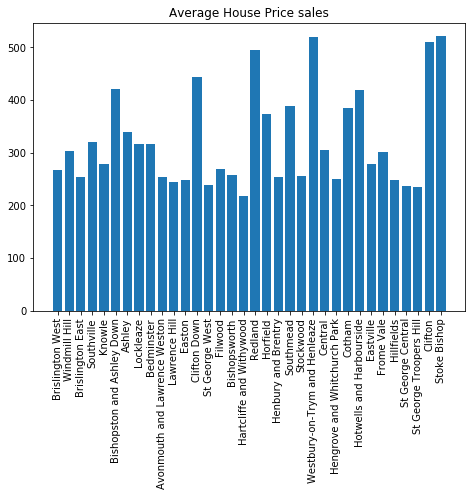

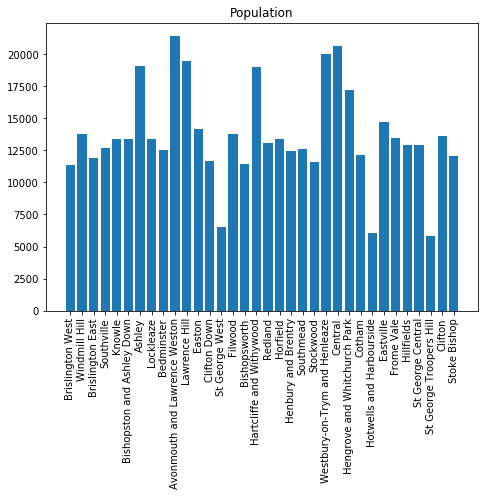

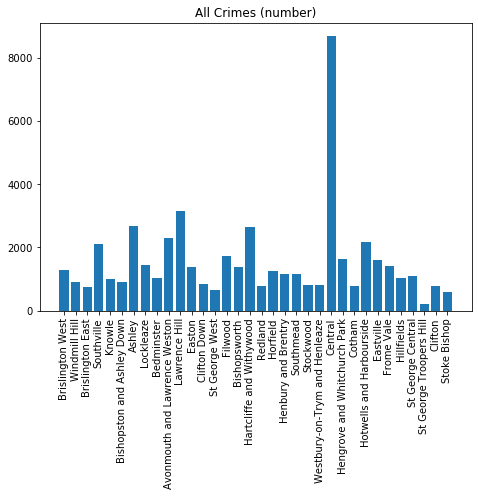

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_wards_final['Ward'],df_wards_final['Ward Avg. House Price £k'])
plt.title("Average House Price sales")
plt.xticks(rotation=90)
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_wards_final['Ward'],df_wards_final['Ward Population'])
plt.title("Population")
plt.xticks(rotation=90)
plt.show()

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_wards_final['Ward'],df_wards_final['Ward Crimes'])
plt.title("All Crimes (number)")
plt.xticks(rotation=90)
plt.show()

In [18]:
address = 'Bristol, United Kingdom'
bristol_latitude = 51.454514
bristol_longitude = -2.587910

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bristol are {}, {}.'.format(latitude, longitude))

# create map of Manhattan using latitude and longitude values
bristol_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_wards_final['Ward Latitude'], df_wards_final['Ward Longitude'], df_wards_final['Ward']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bristol_map)  
    
bristol_map


The geograpical coordinate of Bristol are 51.4538022, -2.5972985.


### Filtered Dataset of Neighboords/Localities

In [73]:
df_Neighbourhoods = df_final_full[['locality', 'Locality Latitude', 'Locality Longitude']]
df_Neighbourhoods.drop_duplicates(inplace=True)
print(df_Neighbourhoods['locality'].unique(), ' ', len(df_Neighbourhoods['locality'].unique()))
df_Neighbourhoods.reset_index(inplace=True)
df_Neighbourhoods = df_Neighbourhoods[['locality', 'Locality Latitude','Locality Longitude']]
df_Neighbourhoods.to_csv("df_Neighbourhoods.csv")
df_Neighbourhoods

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['Arnos Vale' 'Brislington' 'Bristol' 'Knowle' 'Pylle Hill' 'Totterdown'
 'Ashley Down' 'Bishopston' 'Horfield' 'Saint Andrews' 'Ashton'
 'Ashton Gate' 'Bedminster' 'Chittening' 'Kingsweston' 'Lawrence Weston'
 'Shirehampton' 'Avonmouth' 'Avon Valley Business Park' 'Saint Annes'
 'Saint Annes Park' 'Baptist Mills' 'Saint Agnes' 'Saint Judes'
 'Saint Pauls' 'Saint Werburghs' 'Barton Hill' 'Easton' 'Lawrence Hill'
 'Redfield' 'Saint George' 'Whitehall' 'Southville' 'Bedminster Down'
 'Bishopsworth' 'Brentry' 'Westbury-on-Trym' 'Southmead' 'Henbury'
 'Hawkfield Business Park' 'Hengrove Park' 'Stockwood' 'Hengrove'
 'Saint Augustines' 'Stapleton' 'Fishponds' 'Redcliffe' 'Temple Meads'
 'Saint Philips' 'Saint Philips Marsh' 'Kingsdown' 'Saint James'
 'Eastville' 'Greenbank' 'Clay Hill' 'Speedwell' 'Cotham' 'Montpelier'
 'Durdham Park' 'Redland' 'Westbury Park' 'Clifton' 'Tyndalls Park'
 'Clifton Wood' 'Hotwells' 'Sneyd Park' 'Stoke Bishop' 'Coombe Dingle'
 'Sea Mills' 'Henleaze']   70


,locality,Locality Latitude,Locality Longitude
0,Arnos Vale,51.442994,-2.564196
1,Brislington,51.438018,-2.550181
2,Bristol,51.459643,-2.593515
3,Knowle,51.432241,-2.571715
4,Pylle Hill,51.446859,-2.581248
...,...,...,...
65,Sneyd Park,51.472717,-2.633919
66,Stoke Bishop,51.476913,-2.631355
67,Coombe Dingle,51.495613,-2.642429
68,Sea Mills,51.488349,-2.648758


In [20]:
address = 'Bristol, United Kingdom'
bristol_latitude = 51.454514
bristol_longitude = -2.587910

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bristol are {}, {}.'.format(latitude, longitude))

# create map of Manhattan using latitude and longitude values
bristol_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, town in zip(df_Neighbourhoods['Locality Latitude'], 
                                   df_Neighbourhoods['Locality Longitude'], 
                                   df_Neighbourhoods['locality']):
    label = folium.Popup("{}".format(town), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bristol_map)  
    
bristol_map

The geograpical coordinate of Bristol are 51.4538022, -2.5972985.


### Explore 1 km radius of each locality and lookup the Restaurant

For each locality, we are going to explore 1 km radius by fetching all the restaurant with price equals to __3__ and __4__ 

In [21]:
CLIENT_ID = 'P3ST2DNORPJI4CFEP1PCHSDTP3GZVNV3DZYXFIVMIWZ140NM' # your Foursquare ID
CLIENT_SECRET = 'YQL53TVB4HMBT2PFVX0O3AGMPQDF4XHPA2WJMBCJTFAWPHKC' # your Foursquare Secret

In [133]:
from pandas.io.json import json_normalize

df_to_explore = df_Neighbourhoods

VERSION = '20180605' # Foursquare API version
LIMIT = 100

def getNearbyVenues(localities, latitudes, longitudes, radius=1000):
    
    nearby_venues = pd.DataFrame(columns = [
        'locality', 
        'Locality Latitude', 
        'Locality Longitude', 
        'Venue', 
        'Venue Id', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue postalCode', 
        'Venue Category'])
    
    venues_list=[]
    for locality, lat, lng in zip(localities, latitudes, longitudes):

        print(locality)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}&price=3,4&section=food'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            '' ) # ITALIAN RESTAURANT - 4bf58dd8d48988d110941735
        
        #print(url)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']

        for v in results:
            try:
                postalCode = v['venue']['location']['postalCode']
            except:
                postalCode = ""
                
            nearby_venues = nearby_venues.append({
                #code, 
                'locality': locality, 
                'Locality Latitude': lat, 
                'Locality Longitude': lng, 
                'Venue' : v['venue']['name'], 
                'Venue Id' : v['venue']['id'], 
                'Venue Latitude': v['venue']['location']['lat'], 
                'Venue Longitude' : v['venue']['location']['lng'], 
                'Venue postalCode': postalCode, 
                'Venue Category': v['venue']['categories'][0]['name']  
                }, ignore_index=True)
    
    return(nearby_venues)


df_bristol_venues_orig = getNearbyVenues(localities=df_to_explore['locality'],
                                   latitudes=df_to_explore['Locality Latitude'],
                                   longitudes=df_to_explore['Locality Longitude'] #,
                                   #codes=df_to_explore['Ward Code']
                                  )

df_bristol_venues_orig.to_csv("df_bristol_venues_orig.csv")

Arnos Vale
Brislington
Bristol
Knowle
Pylle Hill
Totterdown
Ashley Down
Bishopston
Horfield
Saint Andrews
Ashton
Ashton Gate
Bedminster
Chittening
Kingsweston
Lawrence Weston
Shirehampton
Avonmouth
Avon Valley Business Park
Saint Annes
Saint Annes Park
Baptist Mills
Saint Agnes
Saint Judes
Saint Pauls
Saint Werburghs
Barton Hill
Easton
Lawrence Hill
Redfield
Saint George
Whitehall
Southville
Bedminster Down
Bishopsworth
Brentry
Westbury-on-Trym
Southmead
Henbury
Hawkfield Business Park
Hengrove Park
Stockwood
Hengrove
Saint Augustines
Stapleton
Fishponds
Redcliffe
Temple Meads
Saint Philips
Saint Philips Marsh
Kingsdown
Saint James
Eastville
Greenbank
Clay Hill
Speedwell
Cotham
Montpelier
Durdham Park
Redland
Westbury Park
Clifton
Tyndalls Park
Clifton Wood
Hotwells
Sneyd Park
Stoke Bishop
Coombe Dingle
Sea Mills
Henleaze


In [134]:
########
df_bristol_venues_orig =pd.read_csv("df_bristol_venues_orig.csv")
df_bristol_venues_orig.head()
########

,Unnamed: 0,locality,Locality Latitude,Locality Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue postalCode,Venue Category
0,0,Arnos Vale,51.442994,-2.564196,The Knowle,5648aa54498e6d7530bdd35b,51.434643,-2.562178,NaN,Gastropub
1,1,Arnos Vale,51.442994,-2.564196,Blackcastle,50215cc5e4b09ef8746b8e49,51.444912,-2.572452,NaN,Steakhouse
2,2,Arnos Vale,51.442994,-2.564196,Best Spice,4dae0069a86e29d01a3b51bc,51.439585,-2.573414,BS4 2AL,Indian Restaurant
3,3,Brislington,51.438018,-2.550181,The Knowle,5648aa54498e6d7530bdd35b,51.434643,-2.562178,NaN,Gastropub
4,4,Bristol,51.459643,-2.593515,Poco,4ed9ff2229c2b91227e9f9a5,51.462819,-2.590059,BS2 8JP,Tapas Restaurant


In [135]:
df_bristol_venues = df_bristol_venues_orig.copy()
df_bristol_venues['Distance'] = 0.0

print(df_bristol_venues.columns)

# select only restaurant and remove 'Seafood Restaurant'
df_bristol_venues = df_bristol_venues[(df_bristol_venues['Venue Category'].str.contains('Restaurant')) & (df_bristol_venues['Venue Category']!='Seafood Restaurant') & (df_bristol_venues['Venue Category']!='Restaurant')] 

df_bristol_venues.reset_index(drop=True)

for index, row in df_bristol_venues.iterrows():
    dist = (distance(row['Locality Latitude'], row['Locality Longitude'], row['Venue Latitude'], row['Venue Longitude']))
    df_bristol_venues.loc[index, 'Distance'] = round(dist)

df_bristol_venues.to_csv("df_bristol_venues.csv")

df_bristol_venues.head()

#bristol_venues.sort_values('Distance', ascending=True).drop_duplicates('Venue Id').sort_index()
#bristol_venues.sort_values('Distance', ascending=True).drop_duplicates(keep='first').sort_index()

Index(['Unnamed: 0', 'locality', 'Locality Latitude', 'Locality Longitude',
       'Venue', 'Venue Id', 'Venue Latitude', 'Venue Longitude',
       'Venue postalCode', 'Venue Category', 'Distance'],
      dtype='object')


,Unnamed: 0,locality,Locality Latitude,Locality Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue postalCode,Venue Category,Distance
2,2,Arnos Vale,51.442994,-2.564196,Best Spice,4dae0069a86e29d01a3b51bc,51.439585,-2.573414,BS4 2AL,Indian Restaurant,743.0
4,4,Bristol,51.459643,-2.593515,Poco,4ed9ff2229c2b91227e9f9a5,51.462819,-2.590059,BS2 8JP,Tapas Restaurant,427.0
5,5,Bristol,51.459643,-2.593515,Côte Brasserie,588c7f920319b8631e76e17a,51.457400,-2.587210,BS1 3BU,French Restaurant,503.0
6,6,Bristol,51.459643,-2.593515,Harvey Nichols Restaurant & Bar,50450455183fcb060e8d47e7,51.457233,-2.586228,BS1 3BZ,French Restaurant,572.0
10,10,Bristol,51.459643,-2.593515,Pata Negra,5409ee3f498ea27289eb00e1,51.453950,-2.595134,BS1 1YH,Tapas Restaurant,643.0


### How many restaurants per locality

In [136]:
df_bristol_venues_locality = df_bristol_venues.groupby(['locality','Locality Latitude','Locality Longitude'])['Venue'].count().to_frame(name = 'count').reset_index()
df_bristol_venues_locality
#df_bristol_venues_locality.rename(columns={"Venue": "count"}, inplace=True)

,locality,Locality Latitude,Locality Longitude,count
0,Arnos Vale,51.442994,-2.564196,1
1,Ashton Gate,51.441539,-2.618333,1
2,Bristol,51.459643,-2.593515,7
3,Clifton,51.459352,-2.614886,4
4,Clifton Wood,51.451097,-2.609712,7
5,Cotham,51.466996,-2.596374,2
6,Hotwells,51.449275,-2.618631,3
7,Kingsdown,51.461792,-2.596508,8
8,Knowle,51.432241,-2.571715,1
9,Montpelier,51.467867,-2.585488,1


### Bar diagram for locality venues

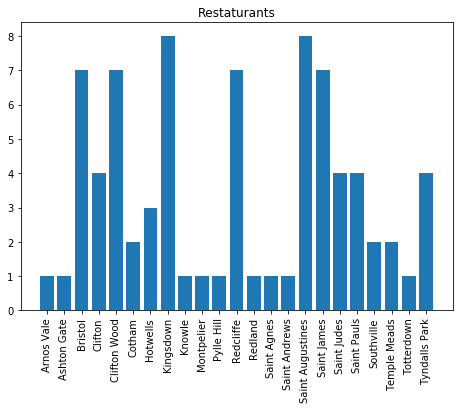

In [137]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_bristol_venues_locality['locality'], df_bristol_venues_locality['count'])
plt.title("Restaturants")
plt.xticks(rotation=90)
plt.show()

In [138]:
print(df_bristol_venues.count())

address = 'Bristol, United Kingdom'
bristol_latitude = 51.454514
bristol_longitude = -2.587910

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bristol are {}, {}.'.format(latitude, longitude))

# create map of Manhattan using latitude and longitude values
bristol_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_bristol_venues['Venue Latitude'], 
                           df_bristol_venues['Venue Longitude'], 
                           df_bristol_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(bristol_map)  
    
bristol_map

Unnamed: 0            78
locality              78
Locality Latitude     78
Locality Longitude    78
Venue                 78
Venue Id              78
Venue Latitude        78
Venue Longitude       78
Venue postalCode      75
Venue Category        78
Distance              78
dtype: int64
The geograpical coordinate of Bristol are 51.4538022, -2.5972985.


### Now the dataset will be reviewed in order to create a column for each specific restaurant

In [139]:
# one hot encoding
df_bristol_onehot = pd.get_dummies(df_bristol_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_bristol_onehot['locality'] = df_bristol_venues['locality'] 


# move neighborhood column to the first column
fixed_columns = [df_bristol_onehot.columns[-1]] + list(df_bristol_onehot.columns[:-1])
bristol_onehot = df_bristol_onehot[fixed_columns]

df_bristol_onehot['Locality Latitude'] = df_bristol_venues['Locality Latitude'] 
df_bristol_onehot['Locality Longitude'] = df_bristol_venues['Locality Longitude'] 

df_bristol_venues_grouped = df_bristol_onehot.groupby(['locality','Locality Latitude', 'Locality Longitude']).mean().reset_index()

## count how many restaurant nationalities
df_tmp = (~df_bristol_venues_grouped.loc[:, df_bristol_venues_grouped.columns[3:-1]].isin([0.0]))
df_bristol_venues_grouped['count rest. nationality'] = df_tmp.sum(axis='columns').to_frame('count')

df_bristol_venues_grouped.to_csv("df_bristol_venues_grouped.csv")
print(df_bristol_venues_grouped['locality'].unique())
print('df_bristol_grouped: ', df_bristol_venues_grouped.shape)
df_bristol_venues_grouped.head()

['Arnos Vale' 'Ashton Gate' 'Bristol' 'Clifton' 'Clifton Wood' 'Cotham'
 'Hotwells' 'Kingsdown' 'Knowle' 'Montpelier' 'Pylle Hill' 'Redcliffe'
 'Redland' 'Saint Agnes' 'Saint Andrews' 'Saint Augustines' 'Saint James'
 'Saint Judes' 'Saint Pauls' 'Southville' 'Temple Meads' 'Totterdown'
 'Tyndalls Park']
df_bristol_grouped:  (23, 9)


,locality,Locality Latitude,Locality Longitude,French Restaurant,Indian Restaurant,Italian Restaurant,New American Restaurant,Tapas Restaurant,count rest. nationality
0,Arnos Vale,51.442994,-2.564196,0.000000,1.0,0.000000,0.000000,0.000000,1
1,Ashton Gate,51.441539,-2.618333,0.000000,0.0,0.000000,0.000000,1.000000,0
2,Bristol,51.459643,-2.593515,0.428571,0.0,0.142857,0.142857,0.285714,3
3,Clifton,51.459352,-2.614886,0.500000,0.0,0.000000,0.000000,0.500000,1
4,Clifton Wood,51.451097,-2.609712,0.285714,0.0,0.000000,0.142857,0.571429,2


In [140]:
df_bristol_venues_grouped['count rest. nationality'].unique()

array([1, 0, 3, 2])

### Adding crime - house price - income

For each of three information we are going to create specific ranges based on 5 bins.

In [141]:
#print(df_final_full.columns)
df_Neighbourhoods_ext1 = df_final_full[['locality', 'Locality Latitude', 'Locality Longitude', 'Ward', 'Ward Code']]

df_Neighbourhoods_ext1 = df_Neighbourhoods_ext1.groupby(['locality','Locality Latitude','Locality Longitude', 'Ward', 'Ward Code'])['Ward'].count().to_frame(name = 'count').reset_index()

df_Neighbourhoods_ext2 = pd.merge(df_Neighbourhoods_ext1,
                            df_wards_final, 
                            how='left', 
                            on=['Ward', 'Ward Code'])

df_Neighbourhoods_ext2.to_csv("df_Neighbourhoods_ext2.csv")

df_tmp1 = df_Neighbourhoods_ext2.groupby("locality").apply(wavg, "Ward Population", "count").to_frame(name = 'Population').reset_index()#reset_index(drop=True)
df_tmp2 = df_Neighbourhoods_ext2.groupby("locality").apply(wavg, "Ward Crimes", "count").to_frame(name = 'Crimes').reset_index()#reset_index(drop=True)
df_tmp3 = df_Neighbourhoods_ext2.groupby("locality").apply(wavg, "Ward Avg. House Price £k", "count").to_frame(name = 'Avg. House Price £k').reset_index()#reset_index(drop=True)
df_tmp4 = df_Neighbourhoods_ext2.groupby("locality").apply(wavg, "Ward Average Income", "count").to_frame(name = 'Average Income').reset_index()#reset_index(drop=True)

df_Neighbourhoods_ext3 = pd.merge(df_Neighbourhoods,
                            df_tmp1, 
                            how='left', 
                            on=['locality'])
df_Neighbourhoods_ext3.to_csv("df_Neighbourhoods_ext3_1.csv")

df_Neighbourhoods_ext3 = pd.merge(df_Neighbourhoods_ext3,
                            df_tmp2, 
                            how='left', 
                            on=['locality'])
df_Neighbourhoods_ext3.to_csv("df_Neighbourhoods_ext3_2.csv")

df_Neighbourhoods_ext3 = pd.merge(df_Neighbourhoods_ext3,
                            df_tmp3, 
                            how='left', 
                            on=['locality'])
df_Neighbourhoods_ext3.to_csv("df_Neighbourhoods_ext3_3.csv")

df_Neighbourhoods_ext3 = pd.merge(df_Neighbourhoods_ext3,
                            df_tmp4, 
                            how='left', 
                            on=['locality'])
df_Neighbourhoods_ext3.to_csv("df_Neighbourhoods_ext3_4.csv")


print('df_Neighbourhoods: ', df_Neighbourhoods.shape)
print('df_Neighbourhoods_ext3: ', df_Neighbourhoods_ext3.shape)

# merger df_bristol_venues_grouped and df_Neighbourhoods_ext3
df_Neighbourhoods_ext4 =  pd.merge(
                            df_bristol_venues_grouped, 
                            df_Neighbourhoods_ext3,
                            how='left', 
                            on=['locality'])

df_Neighbourhoods_ext4.drop(['Locality Latitude_y', 
                       'Locality Longitude_y'], axis=1, inplace=True)
df_Neighbourhoods_ext4.rename(columns={"Locality Latitude_x":"Latitude", "Locality Longitude_x":"Longitude"},inplace=True)
df_Neighbourhoods_ext4.to_csv("df_Neighbourhoods_ext4.csv")
df_Neighbourhoods_ext4.head()

df_Neighbourhoods:  (70, 3)
df_Neighbourhoods_ext3:  (70, 7)


,locality,Latitude,Longitude,French Restaurant,Indian Restaurant,Italian Restaurant,New American Restaurant,Tapas Restaurant,count rest. nationality,Population,Crimes,Avg. House Price £k,Average Income
0,Arnos Vale,51.442994,-2.564196,0.000000,1.0,0.000000,0.000000,0.000000,1,11589.0,1247.0,271.0,43419.0
1,Ashton Gate,51.441539,-2.618333,0.000000,0.0,0.000000,0.000000,1.000000,0,12671.0,2105.0,320.0,43100.0
2,Bristol,51.459643,-2.593515,0.428571,0.0,0.142857,0.142857,0.285714,3,14912.0,2006.0,321.0,42540.0
3,Clifton,51.459352,-2.614886,0.500000,0.0,0.000000,0.000000,0.500000,1,13431.0,1531.0,465.0,53160.0
4,Clifton Wood,51.451097,-2.609712,0.285714,0.0,0.000000,0.142857,0.571429,2,13581.0,781.0,509.0,51629.0


#### Divide in bins

The cut in bins has the following meaning:

* Diversity Restaurant: 
    * [1] very few, [2] few, [3] medium, [4] Many, [5] a lot
* Population:
    * [1] very low, [2] low, [3] medium, [4] high, [5] very high
* Crimes:
    * [5] very low, [4] low, [3] medium, [2] bad, [1] very bad
* Avg. House Price £k:
    * [1] very low", [2] low, [3] medium, [4] high, [5] very high
* Average Income:
    * [1] very low", [2] low, [3] medium, [4] high, [5] very high

In [142]:
df_Neighbourhoods_ext5 = df_Neighbourhoods_ext4.copy()

# cut the restaurants
# "1:very few", "2:few", "3:medium", "4:Many", "5:a lot"
df_Neighbourhoods_ext5['Diversity Restaurant Ranges'] = pd.cut(df_Neighbourhoods_ext5['count rest. nationality'], 5, labels=[1,2,3,4,5])

# "1:very low", "2:low", "3:medium", "4:high", "5:very high"
df_Neighbourhoods_ext5['Population Ranges'] = pd.cut(df_Neighbourhoods_ext5['Population'], 5, labels=[1,2,3,4,5])

# "5: very good", "4: good", "medium", "bad", "very bad"
df_Neighbourhoods_ext5['Crimes Ranges'] = pd.cut(df_Neighbourhoods_ext5['Crimes'], 5, labels=[5 , 4, 3, 2, 1])

# cut the average of house price
# "1:very low", "2:low", "3:medium", "4:high", "5:very high"
df_Neighbourhoods_ext5['Avg. House Price £k Ranges'] = pd.cut(df_Neighbourhoods_ext5['Avg. House Price £k'], 5, labels=[1,2,3,4,5])

# cut the average income
# "1:very low", "2:low", "3: medium", "4:high", "5:very high"
df_Neighbourhoods_ext5['Average Income Ranges'] = pd.cut(df_Neighbourhoods_ext5['Average Income'], 5, labels=[1,2,3,4,5])

#df_wards_final
df_Neighbourhoods_ext5.drop(['Population', 
                       'count rest. nationality',
                       'Crimes', 
                       'Avg. House Price £k', 
                       'Average Income'], axis=1, inplace=True)
df_Neighbourhoods_ext5

,locality,Latitude,Longitude,French Restaurant,Indian Restaurant,Italian Restaurant,New American Restaurant,Tapas Restaurant,Diversity Restaurant Ranges,Population Ranges,Crimes Ranges,Avg. House Price £k Ranges,Average Income Ranges
0,Arnos Vale,51.442994,-2.564196,0.000000,1.0,0.000000,0.000000,0.000000,2,2,5,1,3
1,Ashton Gate,51.441539,-2.618333,0.000000,0.0,0.000000,0.000000,1.000000,1,3,5,2,3
2,Bristol,51.459643,-2.593515,0.428571,0.0,0.142857,0.142857,0.285714,5,4,5,2,3
3,Clifton,51.459352,-2.614886,0.500000,0.0,0.000000,0.000000,0.500000,2,3,5,5,5
4,Clifton Wood,51.451097,-2.609712,0.285714,0.0,0.000000,0.142857,0.571429,4,3,5,5,5
5,Cotham,51.466996,-2.596374,0.000000,0.0,0.000000,0.000000,1.000000,1,3,5,3,5
6,Hotwells,51.449275,-2.618631,0.333333,0.0,0.000000,0.000000,0.666667,2,1,5,4,4
7,Kingsdown,51.461792,-2.596508,0.375000,0.0,0.125000,0.125000,0.375000,5,3,5,3,4
8,Knowle,51.432241,-2.571715,0.000000,1.0,0.000000,0.000000,0.000000,2,3,5,1,2
9,Montpelier,51.467867,-2.585488,0.000000,0.0,0.000000,0.000000,1.000000,1,5,4,2,4


### Clusterizing the localities

Now we are going to clusterize the localities in order to identify the most suitable for the stackholder

In order to find a potential cluster k, the Clusterizing process will be first looped and check a value of inertia as trade of.

In [143]:
bristol_venues_grouped_clustering = df_Neighbourhoods_ext5.drop('locality', 1)

k_vec = []
interia_vec = []
for k in range (1, 11):
    # set number of clusters
    kclusters = k

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bristol_venues_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 	
    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = kmeans.inertia_
    k_vec.append(k)
    interia_vec.append(interia)
    print("k:", k, " cost:", interia)
 

k: 1  cost: 203.80694153738156
k: 2  cost: 118.63739553224599
k: 3  cost: 85.44587017288895
k: 4  cost: 53.86041476593328
k: 5  cost: 36.85897286517847
k: 6  cost: 25.368490612396904
k: 7  cost: 19.55972108820091
k: 8  cost: 14.937237448757449
k: 9  cost: 10.621975136649276
k: 10  cost: 7.4235089754158885


### Plot the k values

([<matplotlib.axis.XTick at 0x7fbac4628470>,
 <a list of 10 Text xticklabel objects>)

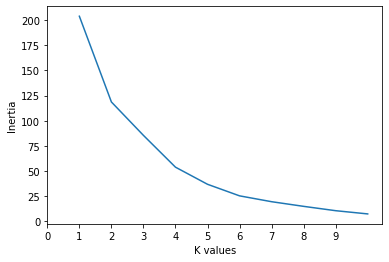

In [144]:
import matplotlib.pyplot as plt

plt.plot(k_vec, interia_vec)
plt.xlabel("K values")
plt.ylabel("Inertia")
plt.xticks(np.arange(0, len(k_vec), 1)) 

By checking the graph an interesting value of K is 6

In [145]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bristol_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 	
# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = kmeans.labels_

In [146]:
##
df_Neighbourhoods_clustered = df_Neighbourhoods_ext5.copy()
df_Neighbourhoods_clustered.insert(0, 'Cluster Labels', kmeans.labels_)
df_Neighbourhoods_clustered

,Cluster Labels,locality,Latitude,Longitude,French Restaurant,Indian Restaurant,Italian Restaurant,New American Restaurant,Tapas Restaurant,Diversity Restaurant Ranges,Population Ranges,Crimes Ranges,Avg. House Price £k Ranges,Average Income Ranges
0,3,Arnos Vale,51.442994,-2.564196,0.000000,1.0,0.000000,0.000000,0.000000,2,2,5,1,3
1,3,Ashton Gate,51.441539,-2.618333,0.000000,0.0,0.000000,0.000000,1.000000,1,3,5,2,3
2,0,Bristol,51.459643,-2.593515,0.428571,0.0,0.142857,0.142857,0.285714,5,4,5,2,3
3,4,Clifton,51.459352,-2.614886,0.500000,0.0,0.000000,0.000000,0.500000,2,3,5,5,5
4,5,Clifton Wood,51.451097,-2.609712,0.285714,0.0,0.000000,0.142857,0.571429,4,3,5,5,5
5,4,Cotham,51.466996,-2.596374,0.000000,0.0,0.000000,0.000000,1.000000,1,3,5,3,5
6,4,Hotwells,51.449275,-2.618631,0.333333,0.0,0.000000,0.000000,0.666667,2,1,5,4,4
7,5,Kingsdown,51.461792,-2.596508,0.375000,0.0,0.125000,0.125000,0.375000,5,3,5,3,4
8,3,Knowle,51.432241,-2.571715,0.000000,1.0,0.000000,0.000000,0.000000,2,3,5,1,2
9,1,Montpelier,51.467867,-2.585488,0.000000,0.0,0.000000,0.000000,1.000000,1,5,4,2,4


### Draw the clusters

In [147]:
############################################################################
address = 'Bristol, United Kingdom'
bristol_latitude = 51.454514
bristol_longitude = -2.587910

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

import math

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, crime, house, population, income  in zip(
                                  df_Neighbourhoods_clustered['Latitude'], 
                                  df_Neighbourhoods_clustered['Longitude'], 
                                  df_Neighbourhoods_clustered['locality'], 
                                  df_Neighbourhoods_clustered['Cluster Labels'],
                                  df_Neighbourhoods_clustered['Crimes Ranges'],
                                  df_Neighbourhoods_clustered['Avg. House Price £k Ranges'],
                                  df_Neighbourhoods_clustered['Population Ranges'],
                                  df_Neighbourhoods_clustered['Average Income Ranges'],
                                 ):
    if(not math.isnan(cluster)):
        label_str = "<b>{}</b> <i>(Cluster {})</i><ul><li>Population: {}</li><li>Crime: {}</li><li>House £: {}</li><li>Incomes: {}</li></ul>".format(
                        poi, str(cluster), population, crime, house, income)
        label = folium.Popup(label_str, parse_html=False)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster-1)],
            fill=True,
            fill_color=rainbow[int(cluster-1)],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto are 51.4538022, -2.5972985.


### Cluster 1

In [160]:
df_Neighbourhoods_clustered.loc[df_Neighbourhoods_clustered['Cluster Labels'] == 0, df_Neighbourhoods_clustered.columns[[1] + list(range(9, df_Neighbourhoods_clustered.shape[1]))]]

,locality,Diversity Restaurant Ranges,Population Ranges,Crimes Ranges,Avg. House Price £k Ranges,Average Income Ranges
2,Bristol,5,4,5,2,3
17,Saint Judes,4,5,4,1,1
18,Saint Pauls,4,5,4,2,3
20,Temple Meads,4,5,4,1,1


### Cluster 2

In [161]:
df_Neighbourhoods_clustered.loc[df_Neighbourhoods_clustered['Cluster Labels'] == 1, df_Neighbourhoods_clustered.columns[[1] + list(range(9, df_Neighbourhoods_clustered.shape[1]))]]

,locality,Diversity Restaurant Ranges,Population Ranges,Crimes Ranges,Avg. House Price £k Ranges,Average Income Ranges
9,Montpelier,1,5,4,2,4
13,Saint Agnes,1,5,4,2,4
14,Saint Andrews,1,5,4,2,4


### Cluster 3

In [162]:
df_Neighbourhoods_clustered.loc[df_Neighbourhoods_clustered['Cluster Labels'] == 2, df_Neighbourhoods_clustered.columns[[1] + list(range(9, df_Neighbourhoods_clustered.shape[1]))]]

,locality,Diversity Restaurant Ranges,Population Ranges,Crimes Ranges,Avg. House Price £k Ranges,Average Income Ranges
11,Redcliffe,5,5,1,2,4
15,Saint Augustines,5,5,1,2,4
16,Saint James,5,5,1,2,4
22,Tyndalls Park,4,5,1,2,4


### Cluster 4

In [163]:
df_Neighbourhoods_clustered.loc[df_Neighbourhoods_clustered['Cluster Labels'] == 3, df_Neighbourhoods_clustered.columns[[1] + list(range(9, df_Neighbourhoods_clustered.shape[1]))]]

,locality,Diversity Restaurant Ranges,Population Ranges,Crimes Ranges,Avg. House Price £k Ranges,Average Income Ranges
0,Arnos Vale,2,2,5,1,3
1,Ashton Gate,1,3,5,2,3
8,Knowle,2,3,5,1,2
10,Pylle Hill,2,3,5,2,3
19,Southville,1,3,5,2,3
21,Totterdown,2,3,5,2,3


### Cluster 5

In [157]:
df_Neighbourhoods_clustered.loc[df_Neighbourhoods_clustered['Cluster Labels'] == 4, df_Neighbourhoods_clustered.columns[[1] + list(range(9, df_Neighbourhoods_clustered.shape[1]))]]

,locality,Diversity Restaurant Ranges,Population Ranges,Crimes Ranges,Avg. House Price £k Ranges,Average Income Ranges
3,Clifton,2,3,5,5,5
5,Cotham,1,3,5,3,5
6,Hotwells,2,1,5,4,4
12,Redland,1,3,5,4,5


### Cluster 6

In [158]:
df_Neighbourhoods_clustered.loc[df_Neighbourhoods_clustered['Cluster Labels'] == 5, df_Neighbourhoods_clustered.columns[[1] + list(range(9, df_Neighbourhoods_clustered.shape[1]))]]

,locality,Diversity Restaurant Ranges,Population Ranges,Crimes Ranges,Avg. House Price £k Ranges,Average Income Ranges
4,Clifton Wood,4,3,5,5,5
7,Kingsdown,5,3,5,3,4


## Result

The cluster 6 is very close to the need of stackholder